# FIT5196-S1-2019 Assessment 2
### Student Name: Rohan Singh
### Student I.D: 30042496
#### Date:15th May,2019
#### Environment: Python 3.6 and Jupyter notebook

### 1. Introduction

We have been given a dataset that provides details about the Uber rides in Victoria, Australia. The data contains information about the following attributes: Uber Type,	Origin Region,	Destination Region,	Origin Latitude,	Origin Longitude,	Destination Latitude,	Destination Longitude,	Journey Distance(m), Departure Date, Departure Time, Travel Time(s), Arrival Time and Fare$. The given dataset is ridden with some errors and anomalies and our task is to cleanse this dataset. Further, we build a model to predict the Fare for some missing values using Linear Regression and finally combine all the data to detect the outliers.

### 2. Loading Libraries

In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime 
import calendar
import sys
import networkx as nx
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from sklearn import *
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

### 3. Sequence of steps followed

1) Structure of the data is checked for any data integrity issues lke nulls or duplication.(use of info() and describe())

2) Syntactic Errors in Uber_Type are found and fixed

3) The Origin and Destination Latitudes are corrected and verified by visualisation on a world map.

4) After getting the correct coordinates, the origin and destination regions are corrected

5) Calculating the correct travel times using Dijkstras Algorithm.

6) Checking if the departure and arrival times need to be swapped.

7) Checking if Departure time + Travel Time = Arrival Time holds true.

8) Fixing the errors in the Departure Date column.

9) Imputing the missing values for Uber Type in 30042496_missing_value.csv

10) Predicting Fare for each uber type, using Linear regression. Thus building 3 different models for the same.

11) Combining data of all 3 files and detecting outliers for the Fare$ column using multivariate boxplot analysis and their respective five point statistics.

12) Removing the outliers from the 30042496_missing_outliers.csv

13) Writing the final outputs to the CSV files.

### 4. Implementation

### 4.1 Examining the structure of Data 

First we upload the given 30042496_dirty_data.csv and replace the empty space in the column names with an underscore(_) for ease of naming columns.

In [195]:
uber=pd.read_csv('30042496_dirty_data.csv') #uploading the ditry data file
print(uber.shape)

(326, 14)


In [196]:
uber.columns =[column.replace(" ", "_") for column in uber.columns]  # replace the empty space in the column names with
uber.head(3)                                                         #an underscore(_) 

Unnamed:_0  Uber_Type  Origin_Region  Destination_Region  \
0  ID1900207058          0              4                   8   
1  ID3611026435          1              3                   1   
2  ID1922931486          0              6                   1   

   Origin_Latitude  Origin_Longitude  Destination_Latitude  \
0       -37.799747        145.002140            -37.815834   
1       -37.816544        144.987228            -37.814862   
2       -37.790818        144.985793            -37.818423   

   Destination_Longitude  Journey_Distance(m) Departure_Date Departure_Time  \
0             145.046450               5509.5     2018-05-02       21:12:48   
1             144.960728               2648.0     2018-06-06       06:10:27   
2             144.965635               4192.0     2018-02-21       14:24:06   

   Travel_Time(s) Arrival_Time  Fare$  
0         1702.02     21:41:10  12.24  
1          648.54      6:21:15   8.34  
2         1064.88     14:41:50   6.99

Now that we have the data,lets look at the description of each column to check the data type and length of attributes.Also we check if there are any data intergrity issues like nulls and duplication.

In [197]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 14 columns):
Unnamed:_0               326 non-null object
Uber_Type                326 non-null int64
Origin_Region            326 non-null int64
Destination_Region       326 non-null int64
Origin_Latitude          326 non-null float64
Origin_Longitude         326 non-null float64
Destination_Latitude     326 non-null float64
Destination_Longitude    326 non-null float64
Journey_Distance(m)      326 non-null float64
Departure_Date           326 non-null object
Departure_Time           326 non-null object
Travel_Time(s)           326 non-null float64
Arrival_Time             326 non-null object
Fare$                    326 non-null float64
dtypes: float64(7), int64(3), object(4)
memory usage: 35.7+ KB


In [198]:
uber.describe()             #description of all float columns

Uber_Type  Origin_Region  Destination_Region  Origin_Latitude  \
count  326.000000     326.000000          326.000000       326.000000   
mean     0.785276       4.938650            4.886503       -36.683401   
std      0.782441       2.509534            2.652604         9.319449   
min      0.000000       1.000000            1.000000       -38.110916   
25%      0.000000       3.000000            2.250000       -37.822748   
50%      1.000000       5.000000            5.000000       -37.813385   
75%      1.000000       7.000000            7.000000       -37.805036   
max      3.000000       9.000000            9.000000        38.110916   

       Origin_Longitude  Destination_Latitude  Destination_Longitude  \
count        326.000000            326.000000             326.000000   
mean         144.935810            -36.686750             144.927566   
std            0.103570              9.328194               0.106269   
min          144.654173            -38.110916             144.654173   
25%          144.928960            -37.824615             144.922370   
50%          144.953045            -37.815349             144.950378   
75%          144.998042            -37.807202             144.985793   
max          145.046450             38.110916             145.046450   

       Journey_Distance(m)  Travel_Time(s)        Fare$  
count           326.000000      326.000000   326.000000  
mean          15868.015951     4118.044110    76.789540  
std           16277.537292     3876.196487   174.688672  
min             882.000000      205.260000     2.450000  
25%            5480.250000     1363.605000    11.090000  
50%            8754.500000     2635.500000    19.585000  
75%           13986.000000     4292.400000    50.535000  
max           51061.000000    13173.360000  1037.320000

In [199]:
uber.describe(include='O')     #description of all object type columns

Unnamed:_0 Departure_Date Departure_Time Arrival_Time
count            326            326            326          326
unique           326            167            326          326
top     ID1928947739     2018-06-06       14:24:06     14:34:26
freq               1              5              1            1

From the above analysis we infer that there are no nulls in the data. There are duplications in the 'Departure Date' column, but it is acceptable since there can be many rides on a single day. 

### 4.1 Checking Uber Type

Now we will check each column sequentially for any syntactic or semantic errors. So we begin with 'Uber Type'.

In [200]:
uber.Uber_Type.unique()

array([0, 1, 2, 3], dtype=int64)

We are given only 3 types of uber cabs, i.e Uber pool, UberX and Uber Black but the data erroneusly shows 4 types : 0,1,2 & 3. Lets see the number of occurences of each of these types in the data. 

In [201]:
uber.Uber_Type.value_counts()

0    139
1    121
2     63
3      3
Name: Uber_Type, dtype: int64

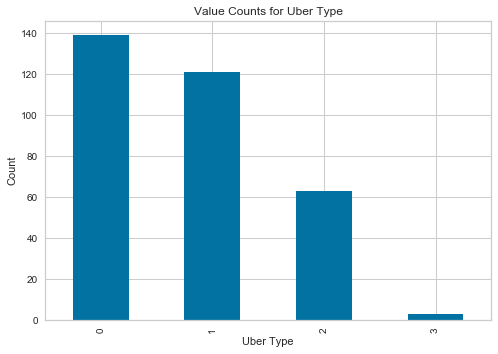

In [202]:
pd.value_counts(uber['Uber_Type']).plot.bar()
plt.ylabel('Count')
plt.xlabel('Uber Type')
plt.title('Value Counts for Uber Type')
plt.show()

In [203]:
uber[uber.Uber_Type == 3]
        

Unnamed:_0  Uber_Type  Origin_Region  Destination_Region  \
136  ID1910508025          3              6                   4   
137  ID1739726016          3              5                   9   
143  ID3652087395          3              4                   3   

     Origin_Latitude  Origin_Longitude  Destination_Latitude  \
136       -37.773845        144.983689            -37.813541   
137       -37.804995        144.931241            -38.110916   
143       -37.812425        144.998788            -37.817134   

     Destination_Longitude  Journey_Distance(m) Departure_Date Departure_Time  \
136             145.010395               7846.0     2018-01-24       22:26:12   
137             144.654173              44308.0     2018-02-05       17:48:46   
143             144.988808               1580.0     2018-05-14       06:57:58   

     Travel_Time(s) Arrival_Time  Fare$  
136         1743.72     22:55:15  10.53  
137        10590.72     20:45:16  20.21  
143          336.54      7:03:34   4.83

Type 3 only occurs thrice in the entire data. This seems to be a syntactic error, may be a mistype. On careful inspection of the ID column we see that there is some relation between ID and Uber type. We find that the third element of the trip ID determines the Uber Type in the following manner:
* If third element of the ID=1 the Uber Type=0
* If third element of the ID=3 the Uber Type=1
* If third element of the ID=5 the Uber Type=2

We will now implement this logic on the Uber_Type column and cleanse it.

In [204]:
ids=list(uber['Unnamed:_0'])                                                       #gets all id in a list
cab_type=[0 if id[2]=='1' else 1 if id[2]=='3' else 2 for id in ids]               #implements the logic
uber['Uber_Type']=cab_type                                                         #writing corrected values to column      

### 4.2 Checking the coordinates

Similary, we check the Origin_Region and Destination region columns.

In [205]:
uber.Origin_Region.unique()

array([4, 3, 6, 7, 5, 1, 2, 9, 8], dtype=int64)

In [206]:
uber.Destination_Region.unique()


array([8, 1, 7, 3, 9, 2, 6, 5, 4], dtype=int64)

We find that regions are classified in 9 distinct groups based on their coordinates(latitudes and longitudes.). Lets plot the Longitudes and Latitudes on a world map to see if the are all in Victoria.

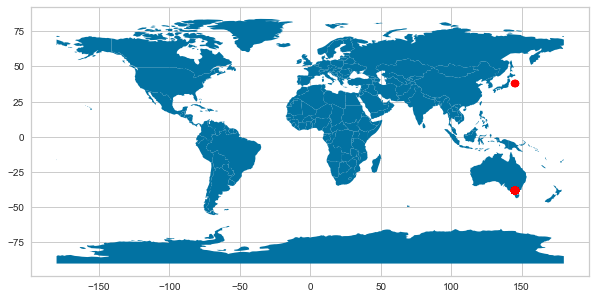

In [207]:
geometry = [Point(xy) for xy in zip(uber['Origin_Longitude'], uber['Origin_Latitude'])]
gdf = GeoDataFrame(uber, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=50);
uber=uber.drop(columns=['geometry'])

The map clearly shows the errors in coordinates of our data. We were given the data for Victoria but it shows that some of the locations in the middle of the sea near Japan. Lets see the Latitudes column for any errors

Since Australia lies below the equator, this means that all the Latitudes should be negative. But we have some positive Latitudes(above equator) in the datatset which need to be converted to negative.

In [208]:
uber[uber.Destination_Latitude>0]["Destination_Latitude"]  #checking Destination Latitudes


72    37.800055
74    37.799360
75    38.110916
76    37.861835
77    38.110916
Name: Destination_Latitude, dtype: float64

In [209]:
uber[uber.Origin_Latitude>0]["Origin_Latitude"]        #checking origin Latitudes

51    37.811237
52    37.810918
54    38.110916
57    37.815834
58    37.802539
Name: Origin_Latitude, dtype: float64

We convert all positive latitudes to negative, by the following code.

In [210]:
uber['Origin_Latitude'] = uber['Origin_Latitude'].abs()*-1             #converting all latitudes to negative
uber['Destination_Latitude'] = uber['Destination_Latitude'].abs()*-1

Lets see how the locations look on the map after this correction:

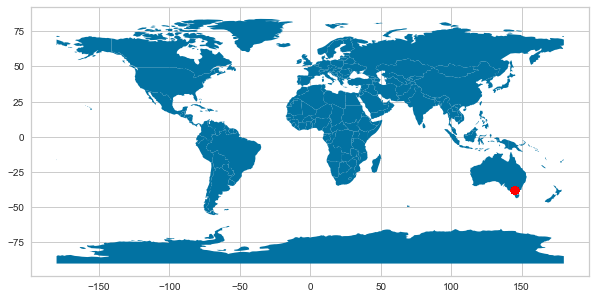

In [211]:
geometry = [Point(xy) for xy in zip(uber['Origin_Longitude'], uber['Origin_Latitude'])]
gdf = GeoDataFrame(uber, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=50);
uber=uber.drop(columns=['geometry'])

As shown by the map above, we have successfully corrected all the locations to Victoria.

### 4.3 Classifying the regions correctly

Now, we need to verify the classification of regions based upon the latitudes and longitudes. To do this we define the following function to measure the distance between a pair of latitudes and longitudes.We are using the Earth's radius = 6378 kms for this purpose.

In [212]:
def spatial_distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6378 # kmliers

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

#### Approach to classify regions.


* We will first define a function that converts the geo-spatial coordinates (latitude,longitude) to cartesian coordinates and returns their centroid back in  geo-spatial coordinates form.

In [213]:
def get_centroid(col):

    sum_x,sum_y,sum_z = 0,0,0
    for value in col.values:
        lat = math.radians(value[0])
        lon = math.radians(value[1])
        ## convert lat lon to cartesian coordinates
        sum_x = sum_x + math.cos(lat) * math.cos(lon)
        sum_y = sum_y + math.cos(lat) * math.sin(lon)
        sum_z = sum_z + math.sin(lat)
    avg_x = sum_x / float(len(col))
    avg_y = sum_y / float(len(col))
    avg_z = sum_z / float(len(col))
    center_lon = math.atan2(avg_y,avg_x)
    hyp = math.sqrt(avg_x*avg_x + avg_y*avg_y) 
    center_lat = math.atan2(avg_z, hyp)
    return (math.degrees(center_lat),math.degrees(center_lon))

* We now combine the origin and destination latitudes and longitudes columns from 30042496_dirty_data.csv, 30042496_missing_value.csv and 30042496_outliers.csv and group them by region.

In [214]:
missing=pd.read_csv('30042496_missing_value.csv')
missing.columns =[column.replace(" ", "_") for column in missing.columns]    #uplooading 30042496_missing_value.csv &
                                                                             #30042496_outliers.csv 
outliers=pd.read_csv('30042496_outliers.csv')
outliers.columns =[column.replace(" ", "_") for column in outliers.columns]


In [215]:
#combining latitude,longitude and region columns in another dataframe for origin and destination.

uber_opoints=uber[['Origin_Latitude','Origin_Longitude','Origin_Region']]
uber_dpoints=uber[['Destination_Latitude','Destination_Longitude','Destination_Region']]
missing_opoints=missing[['Origin_Latitude','Origin_Longitude','Origin_Region']]
missing_dpoints=missing[['Destination_Latitude','Destination_Longitude','Destination_Region']]
outliers_opoints=outliers[['Origin_Latitude','Origin_Longitude','Origin_Region']]
outliers_dpoints=outliers[['Destination_Latitude','Destination_Longitude','Destination_Region']]

#concatenating data of 3 files

all_opoints= pd.concat([uber_opoints,missing_opoints,outliers_opoints],ignore_index=True)   
all_dpoints= pd.concat([uber_dpoints,missing_dpoints,outliers_dpoints],ignore_index=True)
all_opoints['origin_coords']=list(zip(all_opoints['Origin_Latitude'],all_opoints['Origin_Longitude']))
all_dpoints['Destination_coords']=list(zip(all_dpoints['Destination_Latitude'],all_dpoints['Destination_Longitude']))

* We now apply the centroid function on grouped data to find the centroid for each region.

First we do it for origin coordinates:

In [216]:
# Grouping by region for origin coordinates and getting centroid for each region

region = all_opoints.groupby(['Origin_Region'])['origin_coords'].apply(get_centroid).reset_index()
region.rename(columns={'origin_coords':'Centroid'},inplace=True)
region

Origin_Region                                   Centroid
0              1    (-37.81124078405937, 144.9561224328689)
1              2    (-37.81769871580344, 144.9407218266532)
2              3   (-37.82515926679706, 144.97648077185247)
3              4  (-37.806972979456226, 145.00333632615727)
4              5  (-37.807033781952164, 144.92901681981309)
5              6    (-37.78469181364465, 144.9839276674041)
6              7      (-37.8608358480116, 144.906269029602)
7              8  (-37.812223801764006, 145.03636550550482)
8              9   (-38.11091560000001, 144.65417250000002)

* Now we have 9 centroids for 9 regions. So we measure the distance of each (latitude,longitude) in 30042496_outliers.csv from these 9 centroids and assign the (latitude,longitude) pair a region corresponding to the centroid from which it has the shortest distance.

In [217]:
#Finding distances from centroids for Origin Coordinates

origin_coords=list(zip(uber['Origin_Latitude'],uber['Origin_Longitude']))
centroids=list(region['Centroid'])
Origin_Region=[]
for point in origin_coords:
    dist_coord=[]
    for coord in centroids:
        p=(spatial_distance(point,coord),coord)
        dist_coord.append(p)
    dist_coord=sorted(dist_coord, key=lambda x: x[0])
    Origin_Region.append(region[(region.Centroid==dist_coord[0][1])]['Origin_Region'].values[0])

Similarly, we will repeat the process for destination coordinates:

In [218]:
region = all_dpoints.groupby(['Destination_Region'])['Destination_coords'].apply(get_centroid).reset_index()
region.rename(columns={'Destination_coords':'Centroid'},inplace=True)
region

Destination_Region                                   Centroid
0                   1    (-37.81144426531662, 144.9580677373987)
1                   2  (-37.822776872642805, 144.93456611213458)
2                   3   (-37.81852078466777, 144.98392078769064)
3                   4   (-37.80811020329506, 145.00332412109063)
4                   5   (-37.80661723723086, 144.92988633174582)
5                   6   (-37.785049044138844, 144.9806488813259)
6                   7   (-37.86183489999997, 144.90571599999993)
7                   8   (-37.81268024956344, 145.03224760438056)
8                   9          (-38.11091559999999, 144.6541725)

In [219]:
#Finding distances from centroids for Destination Coordinates

Destination_coords=list(zip(uber['Destination_Latitude'],uber['Destination_Longitude']))
centroids=list(region['Centroid'])
Destination_Region=[]
for point in Destination_coords:
    dist_coord=[]
    for coord in centroids:
        p=(spatial_distance(point,coord),coord)
        dist_coord.append(p)
    dist_coord=sorted(dist_coord, key=lambda x: x[0])
    Destination_Region.append(region[(region.Centroid==dist_coord[0][1])]['Destination_Region'].values[0])

* Finally we implement the corrected data to origin region and destination regions in the dirty data file.

In [220]:
uber['Origin_Region']=Origin_Region
uber['Destination_Region']=Destination_Region

### 4.4 Generating the correct Travel Time and Journey Distances (Dikjstras Algorithm)

The next column to check is the Journey distance. We are given that the distance between the nodes is calculated by using the Dijkstra's Algorithm. So now we implement the Dijkstra's using python code.

Firstly we write functions to fetch travel time and distance between 2  nodes using nodes.csv and edges.csv files

In [221]:
edges_df=pd.read_csv('edges.csv')
nodes_df=pd.read_csv('nodes.csv')

def traveltime(path, edges_df):       #returns travel time between nodes

    tt = 0
    for i in range(len(path)-1):
        tt = tt + (edges_df[((edges_df.u==path[i]) & (edges_df.v== path[i+1])) | ((edges_df.v==path[i]) & (edges_df.u== path[i+1]))]['distance(m)'].values[0] * 1.0 * 3600) / (edges_df[((edges_df.u==path[i]) & (edges_df.v== path[i+1])) | ((edges_df.v==path[i]) & (edges_df.u== path[i+1]))]['speed(km/h)'].values[0] * 1000)

    return tt

def distance(path, edges_df):         #returns distance between nodes

    dist = 0
    for i in range(len(path)-1):
        dist = dist + edges_df[((edges_df.u==path[i]) & (edges_df.v== path[i+1])) | ((edges_df.v==path[i]) & (edges_df.u== path[i+1]))]['distance(m)'].values[0]
    return dist


Now, we extract the nodes corresponding to the longitude and latitude columns from nodes.csv.

In [222]:
#Matching node values

uber_olat=list(uber['Origin_Latitude'])
uber_olon=list(uber['Origin_Longitude'])
src_list=[nodes_df[((nodes_df.lat==uber_olat[i]) & (nodes_df.lon==uber_olon[i]))]['Unnamed: 0'].values[0] for i in range(len(uber_olat))]

uber_dlat=list(uber['Destination_Latitude'])
uber_dlon=list(uber['Destination_Longitude'])
des_list=[nodes_df[((nodes_df.lat==uber_dlat[i]) & (nodes_df.lon==uber_dlon[i]))]['Unnamed: 0'].values[0] for i in range(len(uber_dlat))]


Finally we implement the Dijkstras Algorithm using the networkx library.

In [223]:
#Implementing Dijkstras Algorithm

graph=nx.from_pandas_edgelist(edges_df,'u','v',['distance(m)'])
travel_time=[]
journey_distance=[]
for i in range(len(src_list)):
    src=src_list[i]
    des=des_list[i]
    path=nx.dijkstra_path(graph,source=src,target=des,weight='distance(m)')
    travel_time.append(traveltime(path, edges_df))
    journey_distance.append(distance(path, edges_df))

At last we assign the corrected values to the columns in the dirty data.

In [224]:
uber['Travel_Time(s)']=travel_time
uber['Journey_Distance(m)']=journey_distance

### 4.5 Swapping departure and Arrival Times

So at this point, we have correct travel times and journey distances. So lets check the Departure and Arrival times for any errors.

First we'll check if the Departure Time is greater than the Arrival Time. To see this, we subtract the arrival time from departure time and if the value of the resulting time is positive, then departure time > arrival time and we swap times.

But this is not an error for those cases for which the arrival time is just the next day. For eg: Departure time= 23:30:15 and Arrival Time= 1:30:05. Here Departure time is greater than the arrival time but it is not an erroneous data entry. 

To tackle this issue we find the maximum value of the travel time:

In [225]:
uber['Travel_Time(s)'].max()

13173.359999999999

So, max travel time is 13173.36 seconds, i.e approx 3.7 hrs. This means that for any journey the hour difference between any departure and arrival time has to be less than 4 hours. Thus, if we subtract the arrival time from departure time, then any positive value of the hour difference which is less than 4 should be a case where the departure and arrival times have to be swapped.  

Calculating 'Departure_Time'-'Arrival_Time' and the hour difference.

In [226]:
df=uber[['Departure_Time','Travel_Time(s)','Arrival_Time']]     #making a new dataframe to visualise times clearly
df['Departure_Time'] = pd.to_datetime(df['Departure_Time'])      #converting to datetime format
df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time'])
df['time_diff'] = df['Departure_Time']-df['Arrival_Time'] 
df['Hour_diff'] = pd.to_datetime(df['time_diff']).dt.strftime('%H')
df.head(175)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

Departure_Time  Travel_Time(s)        Arrival_Time         time_diff  \
0   2019-05-17 21:12:48         1702.02 2019-05-17 21:41:10 -1 days +23:31:38   
1   2019-05-17 06:10:27          648.54 2019-05-17 06:21:15 -1 days +23:49:12   
2   2019-05-17 14:24:06         1104.66 2019-05-17 14:41:50 -1 days +23:42:16   
3   2019-05-17 15:54:31         3038.22 2019-05-17 16:45:09 -1 days +23:09:22   
4   2019-05-17 18:27:13         3516.24 2019-05-17 19:25:49 -1 days +23:01:24   
5   2019-05-17 11:10:20        11572.62 2019-05-17 14:23:12 -1 days +20:47:08   
6   2019-05-17 01:01:27          502.86 2019-05-17 01:09:49 -1 days +23:51:38   
7   2019-05-17 20:32:21         3494.10 2019-05-17 21:30:35 -1 days +23:01:46   
8   2019-05-17 22:34:45         1069.68 2019-05-17 22:52:34 -1 days +23:42:11   
9   2019-05-17 04:54:48         1643.76 2019-05-17 05:22:11 -1 days +23:32:37   
10  2019-05-17 22:37:42          338.94 2019-05-17 22:43:20 -1 days +23:54:22   
11  2019-05-17 03:01:24         2764.50 2019-05-17 03:47:28 -1 days +23:13:56   
12  2019-05-17 19:37:27         3457.92 2019-05-17 20:35:04 -1 days +23:02:23   
13  2019-05-17 19:07:32        10415.16 2019-05-17 22:01:07 -1 days +21:06:25   
14  2019-05-17 17:23:33         2181.66 2019-05-17 17:59:54 -1 days +23:23:39   
15  2019-05-17 21:30:52         4917.48 2019-05-17 22:52:49 -1 days +22:38:03   
16  2019-05-17 12:43:59         1570.86 2019-05-17 13:10:09 -1 days +23:33:50   
17  2019-05-17 22:22:29         1479.90 2019-05-17 22:47:08 -1 days +23:35:21   
18  2019-05-17 07:35:59         3787.86 2019-05-17 08:39:06 -1 days +22:56:53   
19  2019-05-17 05:07:28         1092.66 2019-05-17 05:25:40 -1 days +23:41:48   
20  2019-05-17 12:57:24         1548.90 2019-05-17 13:23:12 -1 days +23:34:12   
21  2019-05-17 12:51:39          504.54 2019-05-17 13:00:03 -1 days +23:51:36   
22  2019-05-17 08:42:45         3130.98 2019-05-17 09:34:55 -1 days +23:07:50   
23  2019-05-17 04:09:02        11530.62 2019-05-17 07:21:12 -1 days +20:47:50   
24  2019-05-17 20:32:11         1080.12 2019-05-17 20:50:11 -1 days +23:42:00   
25  2019-05-17 05:24:05        10320.36 2019-05-17 08:16:05 -1 days +21:08:00   
26  2019-05-17 06:16:15         4298.28 2019-05-17 07:27:53 -1 days +22:48:22   
27  2019-05-17 00:43:58         1162.80 2019-05-17 01:03:20 -1 days +23:40:38   
28  2019-05-17 20:15:06         4292.40 2019-05-17 21:26:38 -1 days +22:48:28   
29  2019-05-17 05:46:04         3663.78 2019-05-17 06:47:07 -1 days +22:58:57   
..                  ...             ...                 ...               ...   
145 2019-05-17 12:50:25         1755.12 2019-05-17 13:19:40 -1 days +23:30:45   
146 2019-05-17 03:50:35         1699.74 2019-05-17 04:18:54 -1 days +23:31:41   
147 2019-05-17 13:52:03        10542.42 2019-05-17 16:47:45 -1 days +21:04:18   
148 2019-05-17 03:43:52         1918.92 2019-05-17 04:15:50 -1 days +23:28:02   
149 2019-05-17 22:00:59        12681.06 2019-05-17 01:32:20          20:28:39   
150 2019-05-17 13:05:00          787.26 2019-05-17 13:18:07 -1 days +23:46:53   
151 2019-05-17 16:00:17         1032.18 2019-05-17 16:17:29 -1 days +23:42:48   
152 2019-05-17 17:26:06         1161.18 2019-05-17 17:45:27 -1 days +23:40:39   
153 2019-05-17 03:54:17         2438.22 2019-05-17 04:34:55 -1 days +23:19:22   
154 2019-05-17 12:54:55          328.98 2019-05-17 13:00:23 -1 days +23:54:32   
155 2019-05-17 11:47:18        10442.22 2019-05-17 14:41:20 -1 days +21:05:58   
156 2019-05-17 05:05:45          785.22 2019-05-17 04:52:40          00:13:05   
157 2019-05-17 02:05:32         1342.32 2019-05-17 02:27:54 -1 days +23:37:38   
158 2019-05-17 09:50:07        12681.06 2019-05-17 13:21:28 -1 days +20:28:39   
159 2019-05-17 06:28:02         3566.52 2019-05-17 07:27:28 -1 days +23:00:34   
160 2019-05-17 19:50:03          867.90 2019-05-17 20:04:30 -1 days +23:45:33   
161 2019-05-17 03:43:38          647.88 2019-05-17 03:54:25 -1 days +23:49:13   
162 2019-05-17 22:34:30         1754.22 

Now we swap the departure and arrival times where hour difference is less than 4 hours.

In [227]:
# Implementng the swapping of Departure and arrival times

df['Hour_diff']=pd.to_numeric(df['Hour_diff'])
df.loc[df['Hour_diff']<4, ['Departure_Time', 'Arrival_Time']] = df.loc[df['Hour_diff']<4, ['Arrival_Time','Departure_Time']].values
df.head(175)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Departure_Time  Travel_Time(s)        Arrival_Time         time_diff  \
0   2019-05-17 21:12:48         1702.02 2019-05-17 21:41:10 -1 days +23:31:38   
1   2019-05-17 06:10:27          648.54 2019-05-17 06:21:15 -1 days +23:49:12   
2   2019-05-17 14:24:06         1104.66 2019-05-17 14:41:50 -1 days +23:42:16   
3   2019-05-17 15:54:31         3038.22 2019-05-17 16:45:09 -1 days +23:09:22   
4   2019-05-17 18:27:13         3516.24 2019-05-17 19:25:49 -1 days +23:01:24   
5   2019-05-17 11:10:20        11572.62 2019-05-17 14:23:12 -1 days +20:47:08   
6   2019-05-17 01:01:27          502.86 2019-05-17 01:09:49 -1 days +23:51:38   
7   2019-05-17 20:32:21         3494.10 2019-05-17 21:30:35 -1 days +23:01:46   
8   2019-05-17 22:34:45         1069.68 2019-05-17 22:52:34 -1 days +23:42:11   
9   2019-05-17 04:54:48         1643.76 2019-05-17 05:22:11 -1 days +23:32:37   
10  2019-05-17 22:37:42          338.94 2019-05-17 22:43:20 -1 days +23:54:22   
11  2019-05-17 03:01:24         2764.50 2019-05-17 03:47:28 -1 days +23:13:56   
12  2019-05-17 19:37:27         3457.92 2019-05-17 20:35:04 -1 days +23:02:23   
13  2019-05-17 19:07:32        10415.16 2019-05-17 22:01:07 -1 days +21:06:25   
14  2019-05-17 17:23:33         2181.66 2019-05-17 17:59:54 -1 days +23:23:39   
15  2019-05-17 21:30:52         4917.48 2019-05-17 22:52:49 -1 days +22:38:03   
16  2019-05-17 12:43:59         1570.86 2019-05-17 13:10:09 -1 days +23:33:50   
17  2019-05-17 22:22:29         1479.90 2019-05-17 22:47:08 -1 days +23:35:21   
18  2019-05-17 07:35:59         3787.86 2019-05-17 08:39:06 -1 days +22:56:53   
19  2019-05-17 05:07:28         1092.66 2019-05-17 05:25:40 -1 days +23:41:48   
20  2019-05-17 12:57:24         1548.90 2019-05-17 13:23:12 -1 days +23:34:12   
21  2019-05-17 12:51:39          504.54 2019-05-17 13:00:03 -1 days +23:51:36   
22  2019-05-17 08:42:45         3130.98 2019-05-17 09:34:55 -1 days +23:07:50   
23  2019-05-17 04:09:02        11530.62 2019-05-17 07:21:12 -1 days +20:47:50   
24  2019-05-17 20:32:11         1080.12 2019-05-17 20:50:11 -1 days +23:42:00   
25  2019-05-17 05:24:05        10320.36 2019-05-17 08:16:05 -1 days +21:08:00   
26  2019-05-17 06:16:15         4298.28 2019-05-17 07:27:53 -1 days +22:48:22   
27  2019-05-17 00:43:58         1162.80 2019-05-17 01:03:20 -1 days +23:40:38   
28  2019-05-17 20:15:06         4292.40 2019-05-17 21:26:38 -1 days +22:48:28   
29  2019-05-17 05:46:04         3663.78 2019-05-17 06:47:07 -1 days +22:58:57   
..                  ...             ...                 ...               ...   
145 2019-05-17 12:50:25         1755.12 2019-05-17 13:19:40 -1 days +23:30:45   
146 2019-05-17 03:50:35         1699.74 2019-05-17 04:18:54 -1 days +23:31:41   
147 2019-05-17 13:52:03        10542.42 2019-05-17 16:47:45 -1 days +21:04:18   
148 2019-05-17 03:43:52         1918.92 2019-05-17 04:15:50 -1 days +23:28:02   
149 2019-05-17 22:00:59        12681.06 2019-05-17 01:32:20          20:28:39   
150 2019-05-17 13:05:00          787.26 2019-05-17 13:18:07 -1 days +23:46:53   
151 2019-05-17 16:00:17         1032.18 2019-05-17 16:17:29 -1 days +23:42:48   
152 2019-05-17 17:26:06         1161.18 2019-05-17 17:45:27 -1 days +23:40:39   
153 2019-05-17 03:54:17         2438.22 2019-05-17 04:34:55 -1 days +23:19:22   
154 2019-05-17 12:54:55          328.98 2019-05-17 13:00:23 -1 days +23:54:32   
155 2019-05-17 11:47:18        10442.22 2019-05-17 14:41:20 -1 days +21:05:58   
156 2019-05-17 04:52:40          785.22 2019-05-17 05:05:45          00:13:05   
157 2019-05-17 02:05:32         1342.32 2019-05-17 02:27:54 -1 days +23:37:38   
158 2019-05-17 09:50:07        12681.06 2019-05-17 13:21:28 -1 days +20:28:39   
159 2019-05-17 06:28:02         3566.52 2019-05-17 07:27:28 -1 days +23:00:34   
160 2019-05-17 19:50:03          867.90 2019-05-17 20:04:30 -1 days +23:45:33   
161 2019-05-17 03:43:38          647.88 2019-05-17 03:54:25 -1 days +23:49:13   
162 2019-05-17 22:05:16         1754.22 

### 4.6 Checking if Departure time + Travel Time = Arrival Time

We now have the correct departure and travel time. So the Arrival time should be departure time + travel time. So we implement this on our dataset.

In [228]:
df['Travel_Time(s)'] = pd.to_timedelta(df['Travel_Time(s)'], unit='s')
df['New_Arrival_Time'] = df['Departure_Time'] + df['Travel_Time(s)']
df['New_Arrival_Time'] = pd.to_datetime(df['New_Arrival_Time']).dt.strftime('%H:%M:%S')
df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time']).dt.strftime('%H:%M:%S')
df['Departure_Time'] = pd.to_datetime(df['Departure_Time']).dt.strftime('%H:%M:%S')
df.head(10)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

Departure_Time  Travel_Time(s) Arrival_Time         time_diff  Hour_diff  \
0       21:12:48 00:28:22.020000     21:41:10 -1 days +23:31:38         23   
1       06:10:27 00:10:48.540000     06:21:15 -1 days +23:49:12         23   
2       14:24:06 00:18:24.660000     14:41:50 -1 days +23:42:16         23   
3       15:54:31 00:50:38.220000     16:45:09 -1 days +23:09:22         23   
4       18:27:13 00:58:36.240000     19:25:49 -1 days +23:01:24         23   
5       11:10:20 03:12:52.620000     14:23:12 -1 days +20:47:08         20   
6       01:01:27 00:08:22.860000     01:09:49 -1 days +23:51:38         23   
7       20:32:21 00:58:14.100000     21:30:35 -1 days +23:01:46         23   
8       22:34:45 00:17:49.680000     22:52:34 -1 days +23:42:11         23   
9       04:54:48 00:27:23.760000     05:22:11 -1 days +23:32:37         23   

  New_Arrival_Time  
0         21:41:10  
1         06:21:15  
2         14:42:30  
3         16:45:09  
4         19:25:49  
5         14:23:12  
6         01:09:49  
7         21:30:35  
8         22:52:34  
9         05:22:11

At last we include the corrected columns for departure and arrival times in our dataset

In [229]:
uber['Arrival_Time']=df['New_Arrival_Time']
uber['Departure_Time']=df['Departure_Time']


### 4.7 Fixing Departure Date errors

The next column we check is the Departure_Date column by the datetime function which prints NaT for any invalid dates. Lets see which of the dates are invalid.

In [230]:
dates_list=list(uber['Departure_Date'])

for i in range(len(dates_list)):
    check=str(pd.to_datetime(dates_list[i], format="%Y-%m-%d", errors='coerce'))
    if check=='NaT':
        print('Wrong Date : \t',dates_list[i])                 #printig all wrong dates
        
        

Wrong Date : 	 2018-14-07
Wrong Date : 	 2018-22-06
Wrong Date : 	 2018-17-01
Wrong Date : 	 2018-14-06
Wrong Date : 	 2018-16-07
Wrong Date : 	 2018-26-02
Wrong Date : 	 2018-26-07
Wrong Date : 	 2018-02-30
Wrong Date : 	 2018-02-30
Wrong Date : 	 2018-04-31
Wrong Date : 	 2018-02-30
Wrong Date : 	 2018-02-30
Wrong Date : 	 2018-04-31
Wrong Date : 	 2018-06-31
Wrong Date : 	 2018-04-31
Wrong Date : 	 2018-06-31
Wrong Date : 	 2018-06-31


Looking at the wrong dates above,the errors can be categorised in categories:

1) **Format error**: Here the month and date needs to be swapped, so if the month is greater than 12 then we swap it with date to get the correct YYYY-MM-DD format.

2) **Months with 30 days have dates as 31**: Here we increment the month by 1 and write the date as 01 in place of 31

3) **Month of Feb has more than 28 days**: This is not possinble since 2018 is not a leap year. So here we increment the month by 1 and write the date as 02 in place of 30.

The below code implements the above logic.

In [231]:
clean_dates=[]

for i in range(len(dates_list)):
    check=str(pd.to_datetime(dates_list[i], format="%Y-%m-%d", errors='coerce'))
    if check=='NaT':
        
        month=int(dates_list[i].split('-')[1])
        dt=int(dates_list[i].split('-')[2])
        year=int(dates_list[i].split('-')[0])
        
        if month>12:                                           #Month and dates are swapped
            temp=month
            month=dt
            dt=temp 
        
        elif (month==2 and dt==30 and (year % 4) != 0):             #Feb Month of a Non-Leap Year
            month=month+1
            dt=2

        else:                                                   #Months with 30 days having 31st day
            month=month+1
            dt=1
            
        new_dt=(str(year),str(month),str(dt))
        new_date='-'.join(new_dt)
        clean_dates.append(new_date)
        
    else:
        clean_dates.append(dates_list[i])

After applying these changes, lets check if there are any wrong dates lest in the Departure Date Column.

In [232]:
for date in clean_dates:
    check=str(pd.to_datetime(date, format="%Y-%m-%d", errors='coerce'))
    if check=='NaT':
        print('Wrong Date : \t',date)                #printing all wrong dates

So we can confirm that there are no other faults in the Departure Date column and now we can include the corrected column to our dataset.

In [233]:
uber['Departure_Date']=clean_dates

### 4.8 Handling the Missing Data (30042496_missing_value.csv)

### 4.8.1 Imputing Missing Uber Type

The 30042496_missing_value.csv contains some missing data in Uber Type and Fare columns. We find that the third element of the trip ID determines the Uber Type in the following manner:
* If third element of the ID=1 the Uber Type=0
* If third element of the ID=3 the Uber Type=1
* If third element of the ID=5 the Uber Type=2

Remember, we have already uploaded the 30042496_missing_value.csv file earlier while combining data for determining the region types. We will now implement this logic and replace the missing values in the Uber_Type column of this file.

In [234]:
ids=list(missing['Unnamed:_0'])
cab_type=[0 if id[2]=='1' else 1 if id[2]=='3' else 2 for id in ids]
missing['Uber_Type']=cab_type

### 4.8.2 Predicting the Missing Fare Values

The next step is to predict the missing fare values. To do this, we will build a linear model using sklearn library. Here is the list of features that determines our response variable, i.e fare:
* Uber_Type
* Journey_Distance(m)
* Travel_Time(s)
* Departure_day_codes (0--> Weekdays & 1--> Weekends)
* Departure_time_codes (0--> 6:00:00 - 11:59:59 , 1--> 12:00:00 - 20:59:59  &  2--> 21:00 - 5:59:59)

Below are the scatter plots of Travel time vs Fare and Journey Distance vs Fare. 


Text(0.5, 0.98, '')

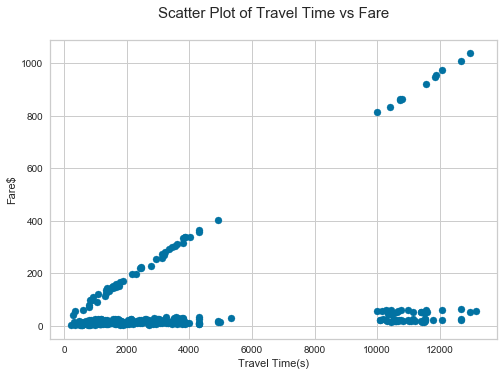

In [255]:
plt.scatter(uber['Travel_Time(s)'],uber['Fare$'])
plt.xlabel('Travel Time(s)')
plt.ylabel('Fare$')
plt.title('Scatter Plot of Travel Time vs Fare\n',fontsize=15)
plt.suptitle('')

Text(0.5, 0.98, '')

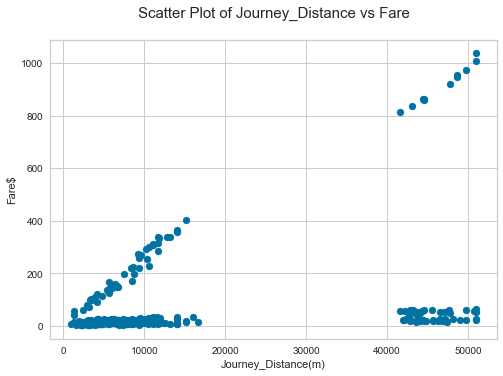

In [256]:
plt.scatter(uber['Journey_Distance(m)'],uber['Fare$'])
plt.xlabel('Journey_Distance(m)')
plt.ylabel('Fare$')
plt.title('Scatter Plot of Journey_Distance vs Fare\n',fontsize=15)
plt.suptitle('')

The Journey Distance and Travel Time seem to have a strong positive correlation with the Fare.

### Test Data

So now we extract all the rows which have null values in the fare column and label it as our test data. Then we add the selected features including the departure time and departure day codes to this dataset.



Here's the function which returns us the days corresponding to dates

In [243]:
def findDay(date): 
    day = datetime.datetime.strptime(date, '%Y-%m-%d').weekday() 
    return (calendar.day_name[day]) 


In [244]:
#The test data

test=missing[missing['Fare$'].isnull()]                       #This is test data for which fare is missing
test = test[['Unnamed:_0','Uber_Type','Journey_Distance(m)','Departure_Date','Departure_Time','Travel_Time(s)','Fare$']]
hours=[int(time.split(':')[0]) for time in test['Departure_Time'].values]
Departure_time_codes=[0 if (hour>=6 and hour<=11) else 1 if (hour>=12 and hour<=20) else 2 for hour in hours]
test['Departure_time_codes']=Departure_time_codes

test['Day'] = test['Departure_Date'].apply(findDay)
Departure_day_codes=[1 if day=='Saturday' or day=='Sunday' else 0 for day in test['Day'].values ]
test['Departure_day_codes']=Departure_day_codes 
test=test[['Unnamed:_0','Uber_Type','Departure_time_codes','Departure_day_codes','Journey_Distance(m)','Travel_Time(s)','Fare$']]
test

Unnamed:_0  Uber_Type  Departure_time_codes  Departure_day_codes  \
41  ID1410278417          0                     0                    1   
42  ID3982486223          1                     1                    0   
52  ID3984338731          1                     2                    1   
55  ID5282071696          2                     2                    0   
56  ID1140315036          0                     1                    0   
59  ID5693002264          2                     2                    0   
61  ID3691281501          1                     2                    0   
64  ID5545700231          2                     2                    0   
67  ID5364913081          2                     0                    0   
72  ID5539741571          2                     2                    0   
73  ID5582530870          2                     2                    0   
74  ID3211421752          1                     1                    1   
76  ID1712665157          0                     1                    1   
77  ID5367510363          2                     1                    0   
80  ID3946349868          1                     2                    0   
82  ID1491848835          0                     1                    0   
84  ID1657619007          0                     2                    0   
85  ID1532355337          0                     1                    1   

    Journey_Distance(m)  Travel_Time(s)  Fare$  
41               5789.0         1492.68    NaN  
42               5595.0         1500.84    NaN  
52              11522.0         3549.30    NaN  
55              47401.0        11464.02    NaN  
56               9196.0         2375.34    NaN  
59               9343.0         3092.58    NaN  
61              44834.0        10880.10    NaN  
64               2718.0          715.14    NaN  
67               7061.0         1739.70    NaN  
72               3528.0          937.80    NaN  
73               6903.0         1729.38    NaN  
74              44691.0        10820.70    NaN  
76              10973.0         3511.32    NaN  
77               2867.0          700.14    NaN  
80               1797.0          421.50    NaN  
82              45805.0        11014.98    NaN  
84               4500.0         1255.26    NaN  
85               4298.0         1080.78    NaN

### Training Data

The rows with non null values of fare are taken as a part of the training data from the 30042496_missing_value.csv file. The final training data is built by combining the 30042496_dirty_data.csv and non null rows of 30042496_missing_value.csv.

In [245]:
missing_train=missing[missing['Fare$'].notnull()]
reg_train=pd.concat([uber,missing_train],ignore_index=True)


Applying Departure time codes to the training data

In [246]:
reg_train = reg_train[['Unnamed:_0','Uber_Type','Journey_Distance(m)','Departure_Date','Departure_Time','Travel_Time(s)','Fare$']]
hours=[int(time.split(':')[0]) for time in reg_train['Departure_Time'].values]
Departure_time_codes=[0 if (hour>=6 and hour<=11) else 1 if (hour>=12 and hour<=20) else 2 for hour in hours]
reg_train['Departure_time_codes']=Departure_time_codes

Applying Departure day codes to the training data

In [247]:
reg_train['Day'] = reg_train['Departure_Date'].apply(findDay)
Departure_day_codes=[1 if day=='Saturday' or day=='Sunday' else 0 for day in reg_train['Day'].values ]
reg_train['Departure_day_codes']=Departure_day_codes  
reg_train.head()

Unnamed:_0  Uber_Type  Journey_Distance(m) Departure_Date Departure_Time  \
0  ID1900207058          0               5504.0     2018-05-02       21:12:48   
1  ID3611026435          1               2648.0     2018-06-06       06:10:27   
2  ID1922931486          0               4192.0     2018-02-21       14:24:06   
3  ID3141586848          1               9229.0     2018-03-06       15:54:31   
4  ID3654759091          1              10722.0     2018-04-10       18:27:13   

   Travel_Time(s)  Fare$  Departure_time_codes        Day  Departure_day_codes  
0         1702.02  12.24                     2  Wednesday                    0  
1          648.54   8.34                     0  Wednesday                    0  
2         1104.66   6.99                     1  Wednesday                    0  
3         3038.22  21.57                     1    Tuesday                    0  
4         3516.24  24.79                     1    Tuesday                    0

Finally we break our entire training data into 3 dataframes with the selected features, one for each Uber Type, namely:
* uber0_train
* uber1_train
* uber2_train
    

In [123]:
features=reg_train[['Unnamed:_0','Uber_Type','Departure_time_codes','Departure_day_codes','Journey_Distance(m)','Travel_Time(s)','Fare$']]
uber0_train=features[features['Uber_Type']==0]
uber1_train=features[features['Uber_Type']==1]
uber2_train=features[features['Uber_Type']==2]

print(uber0_train.shape)
print(uber1_train.shape)
print(uber2_train.shape)
uber0_train.head()

(173, 7)
(155, 7)
(69, 7)


Unnamed:_0  Uber_Type  Departure_time_codes  Departure_day_codes  \
0   ID1900207058          0                     2                    0   
2   ID1922931486          0                     1                    0   
6   ID1993212814          0                     2                    0   
7   ID1412032590          0                     1                    1   
11  ID1251293845          0                     2                    0   

    Journey_Distance(m)  Travel_Time(s)  Fare$  
0                5504.0         1702.02  12.24  
2                4192.0         1104.66   6.99  
6                2106.0          502.86  10.87  
7               10932.0         3494.10  13.36  
11               7913.0         2764.50  12.21

We are looking to build 3 different models, one for each uber type to predict their respective journey fares. We make use of the sklearn library to do the Linear Regression.

### 4.8.2a. Predicting fares for Uber Type= 0

* First we split the uber0_train  data in training and test set

In [124]:
X_train, X_test, y_train, y_test = train_test_split(uber0_train.iloc[:,-6:-1],uber0_train.iloc[:,-1:],random_state=111)

* Then we instantiate the Linear regression object for the uber0_train data and then fit the model on the training set.

In [125]:
uber0_model = LinearRegression() #instantiate
uber0_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Now to evaluate the performance and fit of our model, we will look at the r squared value. An r squared value of above 0.75 is considered as a goo fit. Lets see the r squared value for our model.

In [126]:
uber0_model.fit(X_test,y_test)
print('r-squared for this model = ',uber0_model.score(X_test,y_test))

r-squared for this model =  0.9464958762818462


The r-squared for this model is 0.94.This is a very good fit but it is also approaching the risk of overfitting at the same time. So now we will fit this model on the test data and predict fares for Uber Type=0

In [127]:
uber0_model.fit(uber0_train[[x for x in uber0_train.columns if( x != 'Fare$' and  x != 'Unnamed:_0')]],uber0_train['Fare$'])
test['Fare$'][test['Uber_Type']==0] = uber0_model.predict(test.drop(['Fare$','Unnamed:_0'],axis=1))

In [128]:
test

Unnamed:_0  Uber_Type  Departure_time_codes  Departure_day_codes  \
41  ID1410278417          0                     0                    1   
42  ID3982486223          1                     1                    0   
52  ID3984338731          1                     2                    1   
55  ID5282071696          2                     2                    0   
56  ID1140315036          0                     1                    0   
59  ID5693002264          2                     2                    0   
61  ID3691281501          1                     2                    0   
64  ID5545700231          2                     2                    0   
67  ID5364913081          2                     0                    0   
72  ID5539741571          2                     2                    0   
73  ID5582530870          2                     2                    0   
74  ID3211421752          1                     1                    1   
76  ID1712665157          0                     1                    1   
77  ID5367510363          2                     1                    0   
80  ID3946349868          1                     2                    0   
82  ID1491848835          0                     1                    0   
84  ID1657619007          0                     2                    0   
85  ID1532355337          0                     1                    1   

    Journey_Distance(m)  Travel_Time(s)      Fare$  
41               5789.0         1492.68   9.191056  
42               5595.0         1500.84        NaN  
52              11522.0         3549.30        NaN  
55              47401.0        11464.02        NaN  
56               9196.0         2375.34   9.394182  
59               9343.0         3092.58        NaN  
61              44834.0        10880.10        NaN  
64               2718.0          715.14        NaN  
67               7061.0         1739.70        NaN  
72               3528.0          937.80        NaN  
73               6903.0         1729.38        NaN  
74              44691.0        10820.70        NaN  
76              10973.0         3511.32  14.826093  
77               2867.0          700.14        NaN  
80               1797.0          421.50        NaN  
82              45805.0        11014.98  19.211611  
84               4500.0         1255.26  11.528980  
85               4298.0         1080.78  12.134539

Similarly we predict fares for uber type 1 and 2.

### 4.8.2b. Predicting fares for Uber Type= 1

In [129]:
X_train, X_test, y_train, y_test = train_test_split(uber1_train.iloc[:,-6:-1],uber1_train.iloc[:,-1:],random_state=111)

In [130]:
uber1_model = LinearRegression() #instantiate
uber1_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [131]:
print('r-squared for this model = ',uber1_model.score(X_test,y_test))

r-squared for this model =  0.9827255063668741


In [132]:
uber1_model.fit(uber1_train[[x for x in uber1_train.columns if( x != 'Fare$' and  x != 'Unnamed:_0')]],uber1_train['Fare$'])
test['Fare$'][test['Uber_Type']==1] = uber1_model.predict(test.drop(['Fare$','Unnamed:_0'],axis=1))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [133]:
test

Unnamed:_0  Uber_Type  Departure_time_codes  Departure_day_codes  \
41  ID1410278417          0                     0                    1   
42  ID3982486223          1                     1                    0   
52  ID3984338731          1                     2                    1   
55  ID5282071696          2                     2                    0   
56  ID1140315036          0                     1                    0   
59  ID5693002264          2                     2                    0   
61  ID3691281501          1                     2                    0   
64  ID5545700231          2                     2                    0   
67  ID5364913081          2                     0                    0   
72  ID5539741571          2                     2                    0   
73  ID5582530870          2                     2                    0   
74  ID3211421752          1                     1                    1   
76  ID1712665157          0                     1                    1   
77  ID5367510363          2                     1                    0   
80  ID3946349868          1                     2                    0   
82  ID1491848835          0                     1                    0   
84  ID1657619007          0                     2                    0   
85  ID1532355337          0                     1                    1   

    Journey_Distance(m)  Travel_Time(s)      Fare$  
41               5789.0         1492.68   9.191056  
42               5595.0         1500.84  15.877719  
52              11522.0         3549.30  32.812557  
55              47401.0        11464.02        NaN  
56               9196.0         2375.34   9.394182  
59               9343.0         3092.58        NaN  
61              44834.0        10880.10  56.599206  
64               2718.0          715.14        NaN  
67               7061.0         1739.70        NaN  
72               3528.0          937.80        NaN  
73               6903.0         1729.38        NaN  
74              44691.0        10820.70  54.613162  
76              10973.0         3511.32  14.826093  
77               2867.0          700.14        NaN  
80               1797.0          421.50  17.556114  
82              45805.0        11014.98  19.211611  
84               4500.0         1255.26  11.528980  
85               4298.0         1080.78  12.134539

### 4.8.2c. Predicting fares for Uber Type= 2

In [134]:
X_train, X_test, y_train, y_test = train_test_split(uber2_train.iloc[:,-6:-1],uber2_train.iloc[:,-1:],random_state=111)

In [135]:
uber2_model = LinearRegression() #instantiate
uber2_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [136]:
print('r-squared for this model = ',uber2_model.score(X_test,y_test))

r-squared for this model =  0.9733579562304479


In [137]:
uber2_model.fit(uber2_train[[x for x in uber2_train.columns if( x != 'Fare$' and  x != 'Unnamed:_0')]],uber2_train['Fare$'])
test['Fare$'][test['Uber_Type']==2] = uber2_model.predict(test.drop(['Fare$','Unnamed:_0'],axis=1))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


So now we have predicted the fares for each uber type and the final test data looks as given below:

In [138]:
test

Unnamed:_0  Uber_Type  Departure_time_codes  Departure_day_codes  \
41  ID1410278417          0                     0                    1   
42  ID3982486223          1                     1                    0   
52  ID3984338731          1                     2                    1   
55  ID5282071696          2                     2                    0   
56  ID1140315036          0                     1                    0   
59  ID5693002264          2                     2                    0   
61  ID3691281501          1                     2                    0   
64  ID5545700231          2                     2                    0   
67  ID5364913081          2                     0                    0   
72  ID5539741571          2                     2                    0   
73  ID5582530870          2                     2                    0   
74  ID3211421752          1                     1                    1   
76  ID1712665157          0                     1                    1   
77  ID5367510363          2                     1                    0   
80  ID3946349868          1                     2                    0   
82  ID1491848835          0                     1                    0   
84  ID1657619007          0                     2                    0   
85  ID1532355337          0                     1                    1   

    Journey_Distance(m)  Travel_Time(s)       Fare$  
41               5789.0         1492.68    9.191056  
42               5595.0         1500.84   15.877719  
52              11522.0         3549.30   32.812557  
55              47401.0        11464.02  950.974232  
56               9196.0         2375.34    9.394182  
59               9343.0         3092.58  299.274985  
61              44834.0        10880.10   56.599206  
64               2718.0          715.14   84.788668  
67               7061.0         1739.70  146.112877  
72               3528.0          937.80  103.544074  
73               6903.0         1729.38  166.739216  
74              44691.0        10820.70   54.613162  
76              10973.0         3511.32   14.826093  
77               2867.0          700.14   71.769706  
80               1797.0          421.50   17.556114  
82              45805.0        11014.98   19.211611  
84               4500.0         1255.26   11.528980  
85               4298.0         1080.78   12.134539

Finally we replace the null value in the Fare$ column of 30042496_missing_value.csv with the respective fare values in the test dataset

In [139]:
missing["Fare$"].fillna(test["Fare$"], inplace=True)

### 4.9 Detecting Outliers

#### Approach

We now have the clean data for 30042496_dirty_data.csv and complete data for 30042496_missing_value.csv. To detect the outliers, here are the steps that we follow:

1) Combine the data of 30042496_dirty_data.csv, 30042496_missing_value.csv and 30042496_outliers.csv

2) Plot a multivariate boxplot for the Fare$ column for each Uber type.

3) Calculate the five point statistics for each of the boxplots to get the upper whisker, lower whisker, median, Q1 and Q3 values.

4) Finally filter the 30042496_outliers.csv dataset using the upper whisker value for each uber type.

5) Remove the of the rows having the outliers

In [140]:
outliers=pd.read_csv('30042496_outliers.csv')

To merge this with other two files, we will have to reformat this data set and drop the added index column in the file

In [141]:
outliers_formatted=outliers.drop(columns=['Unnamed: 0'])
outliers_formatted.rename(columns={'Unnamed: 0.1':'Unnamed: 0'},inplace=True)
outliers_formatted.columns =[column.replace(" ", "_") for column in outliers_formatted.columns] 
outliers_formatted.head()

Unnamed:_0  Uber_Type  Origin_Region  Destination_Region  \
0  ID1583150000          0              7                   1   
1  ID3781883579          1              5                   3   
2  ID3146315420          1              8                   1   
3  ID3975059777          1              7                   6   
4  ID1265775613          0              1                   8   

   Origin_Latitude  Origin_Longitude  Destination_Latitude  \
0       -37.861835        144.905716            -37.803422   
1       -37.801067        144.921096            -37.817692   
2       -37.807202        145.026637            -37.820854   
3       -37.861835        144.905716            -37.787433   
4       -37.815846        144.972481            -37.807202   

   Destination_Longitude  Journey_Distance(m) Departure_Date Departure_Time  \
0             144.952486               9758.0     2018-03-08       09:21:45   
1             144.991288               7067.0     2018-04-05       10:12:11   
2             144.954921               7440.0     2018-05-28       00:50:05   
3             144.980377              11633.0     2018-07-27       00:34:25   
4             145.026637               5773.0     2018-05-09       07:41:16   

   Travel_Time(s) Arrival_Time  Fare$  
0         3234.24     10:15:39   7.53  
1         1794.18     10:42:05  11.53  
2         1862.46      1:21:07  22.54  
3         3645.30      1:35:10  28.11  
4         1435.44      8:05:11   6.62

Concatenating the datasets.

In [142]:
total_data=pd.concat([uber,missing,outliers_formatted],ignore_index=True)
total_data.shape

(509, 14)

### 4.9.1 Multivariate Analysis using Boxplots

Text(0, 0.5, 'Fare')

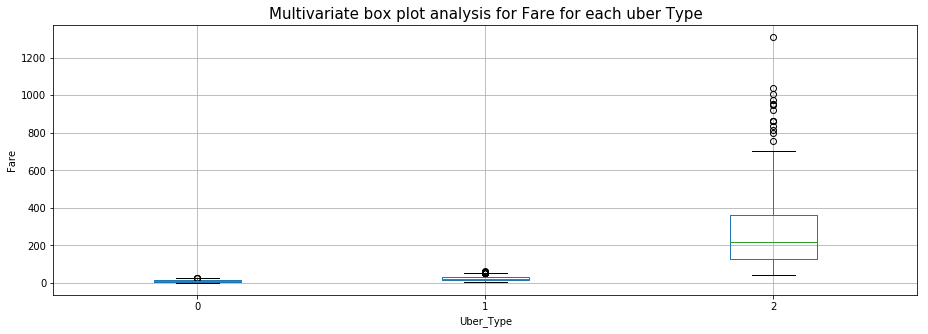

In [143]:
B=total_data.boxplot(column = 'Fare$',by='Uber_Type',figsize=(15,5))
plt.title('Multivariate box plot analysis for Fare for each uber Type',fontsize=15)
plt.suptitle('')
plt.ylabel('Fare')

Lets have a closer look at each boxplot and find their five point statistics:

In [144]:
# Grouping data by uber types

uber0=total_data.loc[total_data['Uber_Type']==0]
uber1=total_data.loc[total_data['Uber_Type']==1]
uber2=total_data.loc[total_data['Uber_Type']==2]

### 4.9.1a. Boxplot for Uber Type=0

Text(0, 0.5, 'Fare')

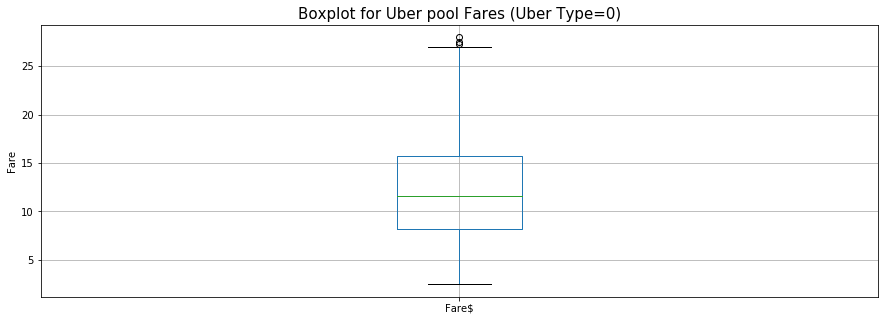

In [145]:
B=uber0.boxplot(column = 'Fare$',figsize=(15,5))
plt.title('Boxplot for Uber pool Fares (Uber Type=0)',fontsize=15)
plt.suptitle('')
plt.ylabel('Fare')

#### Statistics for Uber Type=0

In [146]:
Q1=uber0['Fare$'].quantile(.25)
Q2=uber0['Fare$'].median()
Q3=uber0['Fare$'].quantile(.75)
IQR=Q3-Q1
upper_whisker= Q3+1.5*IQR
lower_whisker= Q1-1.5*IQR

print('Upper whisker : %d'%upper_whisker)
print('Lower whisker : %d'%lower_whisker)
print('Median(Q2) : %d'%Q2)
print('Q1 : %d'%Q1)
print('Q3 : %d'%Q3)

Upper whisker : 27
Lower whisker : -3
Median(Q2) : 11
Q1 : 8
Q3 : 15


### 4.9.1b. Boxplot for Uber Type=1

Text(0, 0.5, 'Fare')

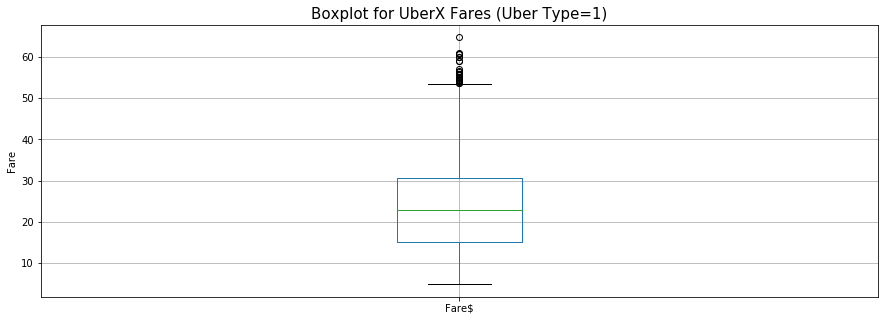

In [147]:
B=uber1.boxplot(column = 'Fare$',figsize=(15,5))
plt.title('Boxplot for UberX Fares (Uber Type=1)',fontsize=15)
plt.suptitle('')
plt.ylabel('Fare')

#### Statistics for Uber Type=1

In [148]:
Q1=uber1['Fare$'].quantile(.25)
Q2=uber1['Fare$'].median()
Q3=uber1['Fare$'].quantile(.75)
IQR=Q3-Q1
upper_whisker= Q3+1.5*IQR
lower_whisker= Q1-1.5*IQR

print('Upper whisker : %d'%upper_whisker)
print('Lower whisker : %d'%lower_whisker)
print('Median(Q2) : %d'%Q2)
print('Q1 : %d'%Q1)
print('Q3 : %d'%Q3)

Upper whisker : 53
Lower whisker : -8
Median(Q2) : 22
Q1 : 15
Q3 : 30


### 4.9.1c. Boxplot for Uber Type=2

Text(0, 0.5, 'Fare')

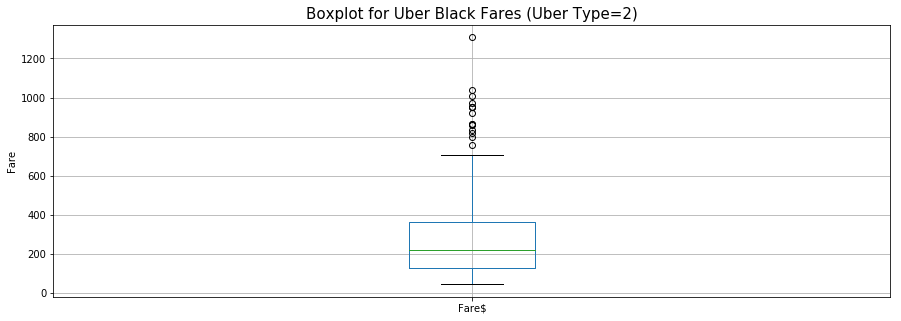

In [149]:
B=uber2.boxplot(column = 'Fare$',figsize=(15,5))
plt.title('Boxplot for Uber Black Fares (Uber Type=2)',fontsize=15)
plt.suptitle('')
plt.ylabel('Fare')

#### Statistics for Uber Type=2

In [150]:
Q1=uber2['Fare$'].quantile(.25)
Q2=uber2['Fare$'].median()
Q3=uber2['Fare$'].quantile(.75)
IQR=Q3-Q1  
upper_whisker= Q3+1.5*IQR
lower_whisker= Q1-1.5*IQR

print('Upper whisker : %d'%upper_whisker)
print('Lower whisker : %d'%lower_whisker)
print('Median(Q2) : %d'%Q2)
print('Q1 : %d'%Q1)
print('Q3 : %d'%Q3)

Upper whisker : 707
Lower whisker : -218
Median(Q2) : 219
Q1 : 128
Q3 : 360


### 4.9.2 Conclusion for outliers:
* Fare values above 27 are outliers for Uber Type= 0
* Fare values above 53 are outliers for Uber Type= 1
* Fare values above 707 are outliers for Uber Type= 2

Finally we remove these outliers from 30042496_outliers.csv file.

In [151]:

# Get names of indexes for the outliers
indexNames0 = outliers[ (outliers['Fare$']>27) & (outliers['Uber Type']==0)].index
indexNames1 = outliers[ (outliers['Fare$']>53) & (outliers['Uber Type']==1)].index
indexNames2 = outliers[ (outliers['Fare$']>707) & (outliers['Uber Type']==2)].index
 
# Delete these ouliers from data
outliers.drop(indexNames0 , inplace=True)
outliers.drop(indexNames1 , inplace=True)
outliers.drop(indexNames2 , inplace=True)

Lets check if all of the outliers have been removed:

In [152]:
outliers.loc[(outliers['Fare$']>27) & (outliers['Uber Type']==0)|(outliers['Fare$']>53)
             & (outliers['Uber Type']==1)|(outliers['Fare$']>707) & (outliers['Uber Type']==2)]

Empty DataFrame
Columns: [Unnamed: 0, Unnamed: 0.1, Uber Type, Origin Region, Destination Region, Origin Latitude, Origin Longitude, Destination Latitude, Destination Longitude, Journey Distance(m), Departure Date, Departure Time, Travel Time(s), Arrival Time, Fare$]
Index: []

In [153]:
outliers.shape

(88, 15)

So finally we have removed all the outliers from the dataset.

### 5. Writing the cleaned outputs to csv files

In [154]:
# Renaming the columns as before

uber.columns =[column.replace("_", " ") for column in uber.columns]
missing.columns =[column.replace("_", " ") for column in missing.columns]
outliers.columns =[column.replace("_", " ") for column in outliers.columns]

In [157]:
uber.rename(columns={'Unnamed: 0':''},inplace=True)
missing.rename(columns={'Unnamed: 0':''},inplace=True)
outliers.rename(columns={'Unnamed: 0':'','Unnamed: 0.1':'Unnamed: 0'},inplace=True)

In [159]:
# Dataframe to csv conversion

uber.to_csv(r'30042496_dirty_data.csv',index=False)
missing.to_csv(r'30042496_missing_value.csv',index=False)
outliers.to_csv(r'30042496_outliers.csv',index=False)